# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
np.random.seed(42)

In [3]:
sns.set_theme()

In [4]:
DATA_PATH = "./mental-health.csv"
ENGLISH_STOPWORDS = set(stopwords.words("english"))
LEMMATIZER = WordNetLemmatizer()

# Functions

In [5]:
def load_data(path: str):
    dataset = pd.read_csv(path)
    descriptions = dataset["text"]
    symptoms = dataset["label"]
    return descriptions, symptoms

In [6]:
def delete_stopwords_from_doc(doc: str):
    doc = word_tokenize(doc)
    doc = [LEMMATIZER.lemmatize(word.lower()) for word in doc if word.lower() not in ENGLISH_STOPWORDS and word.isalpha()]
    return doc

In [7]:
def train_and_score_model(model, X_train, y_train, X_test, y_test):
    start = time.time()
    
    model_instance = model()
    model_instance.fit(X_train, y_train)
    model_score = model_instance.score(X_test, y_test)
    
    # Indicates how much time did it take to train the model.
    end = time.time() - start
    
    return model_instance, model_score, end

In [8]:
def get_models_results(models_dict):
    _, ax = plt.subplots()
    
    labels = list(models_dict.keys())
    models_data = list(models_dict.items())
    
    for data in models_data:
        label = data[0]
        data = data[1]
        ax.scatter(data[1], data[2], label=label)

    
    ax.set_title("Accuracy vs training time")
    ax.set_xlabel("Score")
    ax.set_ylabel("Training time")
    ax.legend(labels)
    
    plt.show()
    

In [9]:
def save_object(obj, filename):
    with open(f"{filename}.pickle", "wb") as file:
        pickle.dump(obj, file)

In [10]:
def read_object(filename):
    with open(f"{filename}.pickle", "rb") as file:
        return pickle.load(file)

# Data exploration

In [11]:
X, y = load_data(DATA_PATH)

In [12]:
len(X), len(y)

(20364, 20364)

In [13]:
unique_labels = y.unique()
unique_labels

array(['depression', 'SuicideWatch'], dtype=object)

In [14]:
depression_symptom_num = len(y[y == "depression"])
suicide_symptom_num = len(y[y == "SuicideWatch"])
depression_symptom_num, suicide_symptom_num

(10371, 9993)

Text(0.5, 0, 'No. of occurences in dataset')

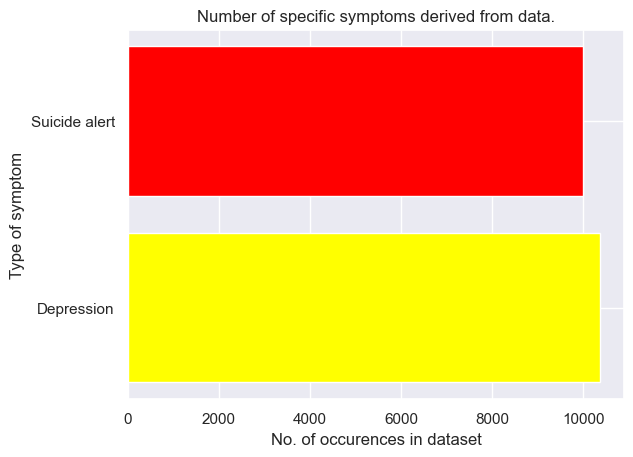

In [15]:
labels = ["Depression", "Suicide alert"]
values = [depression_symptom_num, suicide_symptom_num]

fig, ax = plt.subplots()

ax.set_title("Number of specific symptoms derived from data.")
ax.barh(labels, values, color=["yellow", "red"])
plt.ylabel("Type of symptom")
plt.xlabel("No. of occurences in dataset")

# Data preparation

In [16]:
encoder = LabelEncoder()
encoder.fit(unique_labels)
encoder.classes_,

(array(['SuicideWatch', 'depression'], dtype=object),)

In [32]:
encoder.transform(["SuicideWatch"])

ValueError: y should be a 1d array, got an array of shape () instead.

In [17]:
X = X.apply(delete_stopwords_from_doc)

In [18]:
y = encoder.fit_transform(y)

In [19]:
X_sentences = [" ".join(doc) for doc in X]

In [20]:
tfidf = TfidfVectorizer()

In [21]:
X_tfidf = tfidf.fit_transform(X_sentences)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y)

# Modeling

In [23]:
models_results = {}

In [24]:
model, score, training_time = train_and_score_model(MultinomialNB, X_train, y_train, X_test, y_test)
models_results["MultinomialNB"] = [model, score, training_time]

In [25]:
model, score, training_time = train_and_score_model(SVC, X_train, y_train, X_test, y_test)
models_results["SVC"] = [model, score, training_time]

In [29]:
models_results["SVC"][1]

0.7424867413081909

In [26]:
model, score, training_time = train_and_score_model(LinearSVC, X_train, y_train, X_test, y_test)
models_results["LinearSVC"] = [model, score, training_time]

d:\Conda\envs\NLP\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [27]:
model, score, training_time = train_and_score_model(RandomForestClassifier, X_train, y_train, X_test, y_test)
models_results["RandomForestClassifier"] = [model, score, training_time]

KeyboardInterrupt: 

In [ ]:
model, score, training_time = train_and_score_model(SGDClassifier, X_train, y_train, X_test, y_test)
models_results["SGDClassifier"] = [model, score, training_time]

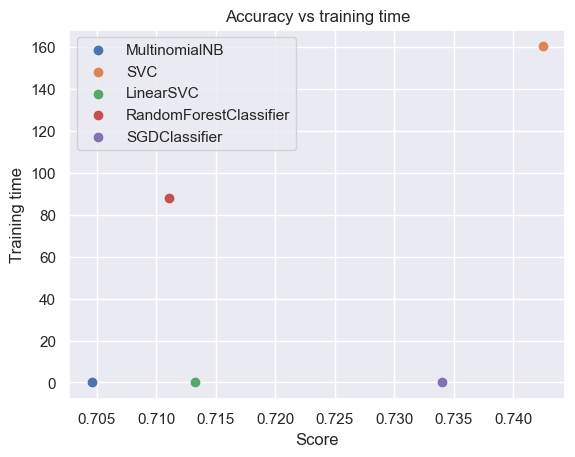

In [ ]:
get_models_results(models_results)

# Hyperparameters tuning

We will go only with SVC and SGDClassifier because they are giving us the best results.

In [47]:
svc_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

In [49]:
sgd_param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
}

In [50]:
svc_random_search = RandomizedSearchCV(SVC(), svc_param_grid, n_iter=10, cv=5, random_state=42)
svc_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': [0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=42)

In [51]:
sgd_random_search = RandomizedSearchCV(SGDClassifier(), sgd_param_grid, n_iter=10, cv=5, random_state=42)
sgd_random_search.fit(X_train, y_train)

d:\Conda\envs\NLP\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Conda\envs\NLP\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Conda\envs\NLP\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "d:\Conda\envs\NLP\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "d:\Conda\envs\NLP\lib\site-packages\sklearn\utils\_param_validation.py"

RandomizedSearchCV(cv=5, estimator=SGDClassifier(),
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1],
                                        'loss': ['hinge', 'log',
                                                 'modified_huber',
                                                 'squared_hinge',
                                                 'perceptron'],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   random_state=42)

In [52]:
best_svc_model = svc_random_search.best_estimator_
best_svc_score = svc_random_search.best_score_

In [53]:
best_sgd_model = sgd_random_search.best_estimator_
best_sgd_score = sgd_random_search.best_score_

In [54]:
print("Best SVC Model:", best_svc_model)
print("Best SVC Score:", best_svc_score)

Best SVC Model: SVC(C=0.1, gamma=0.1, kernel='linear')
Best SVC Score: 0.7254627399659378


In [55]:
print("Best SGDClassifier Model:", best_sgd_model)
print("Best SGDClassifier Score:", best_sgd_score)

Best SGDClassifier Model: SGDClassifier(penalty='l1')
Best SGDClassifier Score: 0.721796040073012


In [62]:
save_object(models_results["SVC"][0], "svc")

In [ ]:
save_object(tfidf, "vectorizer")

In [65]:
obj = read_object("svc")